# Import

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
region = 3
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/CALABARZON/calabarzon_clusters.csv")
raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'neighbours.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")
candidate_sites

'''AGGREGATING THE POPULATION'''
# Assuming df is your DataFrame
# vp =  raw_rg1_clustered['popden_chi'] + raw_rg1_clustered['popden_eld'] + raw_rg1_clustered['popden_wom'] + raw_rg1_clustered['popden_you'] + raw_rg1_clustered['popden_w_1'] + raw_rg1_clustered['popden_you']
# gen = raw_rg1_clustered['popden_all'] - vp
# all = vp + gen
# raw_rg1_clustered['total_population'] = all
# raw_rg1_clustered.columns

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['HCFAI.1'])
raw_rg1_clustered.columns

Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')

# Generate

In [3]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    print(f"{len(candidate_sites)} Candidate sites left")
    print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    print("Original HCFAI:", original_HCFAI)
    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])]
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
        print("Updated HCFAI:", updated_HCFAI)
        print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# LGA: trained rg1 model

In [ ]:
print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF = 968
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
print(selected_facilities.to_string(index=False))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
# hex_with_RHU = list(hex_with_RHU['ID'])
# hex_with_RHU
print(f"{len(list(cs))} Candidate sites")
print(f"{cs}")
print(f"{len(list(set(os)))} Optimal sites")
print(f"{list(set(os))}")
print(f"{len(list(hex_with_RHU['ID']))} Sites with RHUs")
print(f"{list(hex_with_RHU['ID'])}")

4624 Candidate sites
[2869579, 2869580, 2869581, 2870961, 2870962, 2870963, 2879252, 2880635, 2882031, 2882033, 2883415, 2883416, 2884780, 2884798, 2886179, 2886181, 2891689, 2891690, 2891717, 2893069, 2893070, 2893071, 2893072, 2893073, 2893100, 2893102, 2893103, 2893107, 2894451, 2894452, 2894453, 2894454, 2894455, 2894456, 2894457, 2894459, 2894476, 2894477, 2894479, 2894481, 2894482, 2894483, 2894484, 2894485, 2894486, 2894487, 2894489, 2894490, 2894494, 2895832, 2895833, 2895834, 2895835, 2895836, 2895837, 2895838, 2895840, 2895847, 2895854, 2895855, 2895857, 2895858, 2895859, 2895860, 2895863, 2895864, 2895865, 2895866, 2895867, 2895868, 2895869, 2895870, 2895871, 2895872, 2895875, 2895876, 2895877, 2897216, 2897217, 2897218, 2897220, 2897221, 2897229, 2897236, 2897237, 2897238, 2897239, 2897240, 2897241, 2897242, 2897244, 2897245, 2897246, 2897247, 2897248, 2897249, 2897250, 2897251, 2897253, 2897255, 2897257, 2897258, 2897259, 2897260, 2897261, 2897262, 2897264, 2897266, 289727

In [ ]:
print(og_HCFAI)
print(updated_HCFAI)

3081.3435189444444
3602.5759369677507


# LGA: trained rg3 model

In [4]:
print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF = 730#1368#1407
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
print(selected_facilities.to_string(index=False))

os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
# hex_with_RHU = list(hex_with_RHU['ID'])
# hex_with_RHU
print(f"{len(list(cs))} Candidate sites")
print(f"{cs}")
print(f"{len(list(set(os)))} Optimal sites")
print(f"{list(set(os))}")
print(f"{len(list(hex_with_RHU['ID']))} Sites with RHUs")
print(f"{list(hex_with_RHU['ID'])}")

print(og_HCFAI)
print(updated_HCFAI)

Candidate sites: 2549
Original HCFAI: 3081.3435189444444
1715 Candidate sites left
This is what we'll put on QGIS: [3007802, 3005036, 3006419, 2930409, 2929026, 2930407, 2931791, 2933170, 2927641, 2934586, 2923531, 2923526, 2929025, 2929023, 2924869, 2922107, 2920726, 2926251, 2923488, 2923489, 2935944, 2934562, 2937326, 2934563, 2935946, 2934550, 3018901, 3017519, 2933171, 3013300, 3005007, 2927639, 2933176, 2933178, 2934556, 2933174, 2933173, 2934560, 2938704, 2938706, 2937319, 2935936, 2935942, 2937322, 2937323, 2937324, 2934566, 2937330, 2941478, 2941477, 2941476, 2947005, 2937329, 2945623, 2933186, 2937332, 2937331, 2938713, 2933187, 2940095, 2940094, 2942858, 2935950, 2938714, 2935949, 2942859, 2941495, 2942875, 2941493, 2941494, 2938731, 2937348, 2940113, 2935966, 2937349, 2935967, 2941511, 2926299, 2920774, 2935973, 2937357, 2934591, 2935975, 2933211, 2944257, 2945638, 2937365, 2947011, 2941486, 2948392, 2944248, 2941484, 2942867, 2942866, 2942865, 3002243, 2935935, 2934552, 29

# Validation - trained rg1 model

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

# rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

2650.439143826631
430.90437511781386
2648.7468003902013
432.5967185542436
2650.634457981339
430.7090609631058
2651.46761940618
429.8758995382649
2650.787340849469
430.55617809497585
2648.9668699520535
432.3766489923911
2647.859837524051
433.4836814203939
2648.7636004659457
432.57991847849905
2646.2829452146716
435.06057372977284
2651.6978617488685
429.64565719557595
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 3081.3435189444444
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  3081.343518944445
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  3602.5759369677507


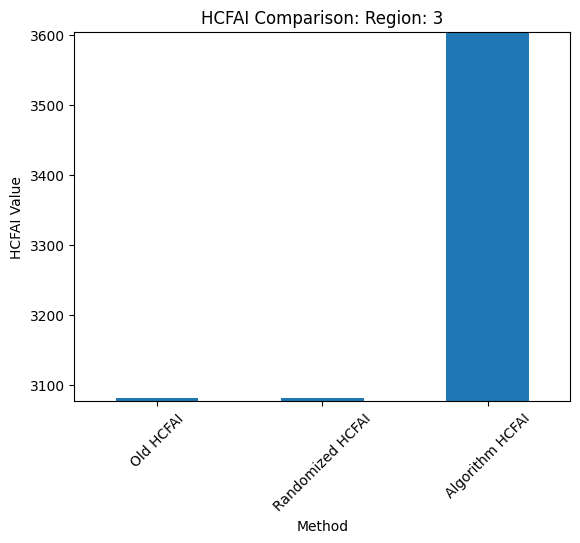

In [ ]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region: {region}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()

# Validation - trained rg3

2730.994058529077
350.3494604153676
2730.7594810199867
350.5840379244581
2730.1149519148244
351.2285670296203
2731.9815038880033
349.3620150564416
2730.151516581383
351.1920023630617
2730.227863334897
351.1156556095478
2730.3902220594005
350.9532968850443
2731.5375099083803
349.80600903606444
2731.225091239575
350.11842770486965
2732.4038994983994
348.93961944604496
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 3081.3435189444444
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  3081.343518944445
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  3284.8119973476305


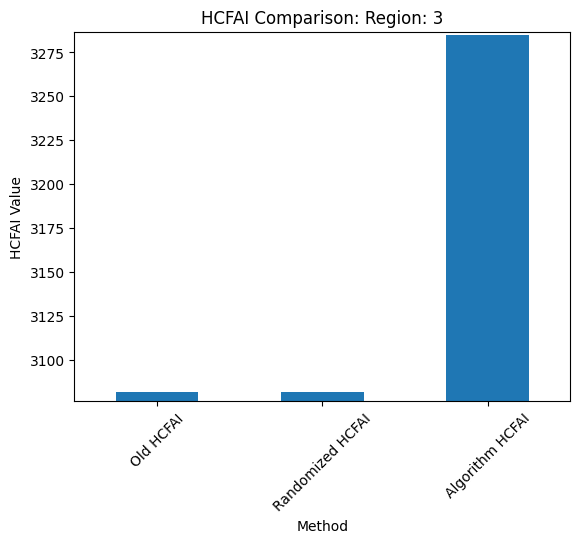

In [5]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

# rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region: {region}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()